In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "svg"
from pymc3 import *
import arviz as az

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Simpson's paradox

In class we saw how binning, or pooling data, in order to covert a binary variable into a fraction can give missleading results due to an effect known as **Simpson's paradox**. Simpson's paradox arrises when the association of a variable **within** a group is different from the association **between** groups. There are many examples where people have been mislead by this effect.


**Exercises**



1.1 Read [this](https://www.washingtonpost.com/outlook/2021/08/31/covid-israel-hospitalization-rates-simpsons-paradox/) article (you may need to access it through the library). Think about the connection to regression modeling and binning. 

Why could it be misleading to study the fraction of hospitalizations or severe illnesses as a function of the fraction of people vaccinated across different countries? 

1.2 The following code (loosely inspired by the article) will generate some simulated data for 100 hypothetical countries with similar population sizes. In each country we have data for covid cases, their vaccination status and whether their case was severe. Although their age group (whether they are over 60), was used to generate the data, we are pretending we don't have access to that information. We then bin the data by country. This is exactly the type of simulation which can be helpful when we want to test our regression model on data where we *know* the underlying model.



```
n_cases = 50000
country =  np.random.choice(range(100),size=n_cases)

# the chance that someone is over 60 depends strongly on the country
# for half the countries 0.7 percent of people will be over 60
# for the other hald it is 0.1
q_over60 = np.array([0.1 if c <50 else 0.7 for c in country])

# determine whether people are over 60
over60 = np.array([np.random.choice([0,1],p=[1-q,q]) for q in q_over60])

# the  chance to be vaccinated depends on whether someone is over 60
q_vax = 0.8*over60 + 0.3*(1-over60)
vax = np.array([np.random.choice([0,1],p=[1-q,q]) for q in q_vax])

# the chance to have a severe case depends on whether someone is vaccinated and over 60
q_sev = 0.2*over60*(1-vax) + 0.015*over60*vax + 0.0004*(1-over60)*vax + 0.01*(1-over60)*(1-vax)
sev= np.array([np.random.choice([0,1],p=[1-q,q]) for q in q_sev])

# put everything in a dataframe
data =pd.DataFrame(np.transpose(np.array([sev,vax,country])),columns = ["sev","vax","country"])
data

countries = np.unique(data.country)
x = [] # fraction of cases vaccinated
y = []  # fraction of cases with severe illness
for c in countries:
  cdata = data[data.country ==c]
  y.append(np.mean(cdata.sev)*100))
  x.append(np.mean(cdata.vax)*100)

```



Show that if we fit the data to a linear regression model in statsmodels after binning by country and computing the fraction of servere cases, we obtain a possitive association between the fraction of people vaccinated and the fraction of severe cases. (This is assuming we don't use age as a predictor). In particular, explain the interpretation of the regression coefficient you get. 

1.3 After fitting the model make a residual plot. Does anything about the residual plot suggest that this model will not yield accurate predictions for the average number of severe cases in a country given the fraction of people vaccinated? 

1.4 (optional) Copy and paste the code used to generate the data and make a new dataframe called `data_test`. Using the new data, compute the fraction of people vaccinated and the fraction of severe cases within each country. Test how well the fitted model can predicted the fraction of severe cases by making a plot of the predicted fraction vs. the actual fraction for each country. Comment on this plot. What do you notice about the relationship between the predictions and the actualy fractions? 

1.5 (optional) Read [this](https://www.bostonglobe.com/2020/06/11/opinion/statistical-paradox-police-killings/) article. Think about the connection to regression modeling and binning. If we frame the example given in this article as a linear regression problem, what are the predictors and what is the response variable in this context? If interested, try generating some simulated data to help you better understand the example. 



1.1

If we study the fraction of hospitalizations or severe illnesses as a function of the fraction of people vaccinated across different countries, then we could disguise the variation within countries when we group all people from each country together. As seen in the article, demographics differ between countries. Some countries may have a lot more elderly people which can lead to more hopsitalizations regardless of vaccination status. Thus, a country with a high demographic of older people may have a higher fraction of hospitalizations despite having a higher fraction of people vaccinated than a country with a demogaphic of younger people. However, if we look within each city, we find that for older people who are vaccinated, there is a lower rate of hospitalizations compared to older people who aren't vaccinated. This applies to younger people as well. For younger people who are vaccinated, there is a lower rate of hospitalizations compared to younger people who aren't vaccinated. The sheer population size can also affect the statistics in terms of vaccination rates and hospitalization rates. Thus, if we find that more vaccinated people are being hospitalized than unvaxxed, it may just be because of larger number of elderly people that disproportionately represents the vaccinated population. Combining all of the countries' demographics could easily lead to a misrepresentation of hospitalization rates within countries. 

In [ ]:
# 1.2

n_cases = 50000
country =  np.random.choice(range(100),size=n_cases)

# the chance that someone is over 60 depends strongly on the country
# for half the countries 0.7 percent of people will be over 60
# for the other hald it is 0.1
q_over60 = np.array([0.1 if c <50 else 0.7 for c in country])

# determine whether people are over 60
over60 = np.array([np.random.choice([0,1],p=[1-q,q]) for q in q_over60])

# the  chance to be vaccinated depends on whether someone is over 60
q_vax = 0.8*over60 + 0.3*(1-over60)
vax = np.array([np.random.choice([0,1],p=[1-q,q]) for q in q_vax])

# the chance to have a severe case depends on whether someone is vaccinated and over 60
q_sev = 0.2*over60*(1-vax) + 0.015*over60*vax + 0.0004*(1-over60)*vax + 0.01*(1-over60)*(1-vax)
sev= np.array([np.random.choice([0,1],p=[1-q,q]) for q in q_sev])

# put everything in a dataframe
data =pd.DataFrame(np.transpose(np.array([sev,vax,country])),columns = ["sev","vax","country"])
data

countries = np.unique(data.country)
x = [] # fraction of cases vaccinated
y = []  # fraction of cases with severe illness
for c in countries:
  cdata = data[data.country ==c]
  y.append(np.mean(cdata.sev)*100)
  x.append(np.mean(cdata.vax)*100)

sm_model = sm.OLS(y,sm.add_constant(x))
results = sm_model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     290.7
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           4.43e-31
Time:                        16:29:13   Log-Likelihood:                -112.59
No. Observations:                 100   AIC:                             229.2
Df Residuals:                      98   BIC:                             234.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8033      0.259     -6.970      0.0

As we see here, we find our correlation coefficient to be about 0.08, which means that for every 1 person increase in vaccinated status, there is a 0.08 increase in severe Covid cases. In other words, for every increase of 100 vaccinated cases, there is an increase of 8 severe cases.

Text(0, 0.5, 'residual')

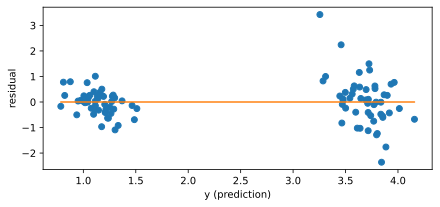

In [ ]:
# 1.3

r = results.resid
y_mean_pred = y-r

fig,ax = plt.subplots(figsize=(7,3))
ax.plot(y_mean_pred,r,"o")
ax.plot(y_mean_pred,np.zeros(len(y)),"-")
ax.set_xlabel("y (prediction)")
ax.set_ylabel("residual")

As we can see here, the residuals are clumped around the y values around 3.75 and 1.3, with different variations. Since the variation differs between the 2 clumps, it is likely that our model is not a good fit for the data. In addition, the residuals around 1.3 are less variable than the residuals around 3.75 meaning they are not normally distributed and our model is not a good fit.

# Logistic regression

The approach of binning binary data and fitting to a linear regression model has some major pitfalls that we have discussed. In most cases this is not the preferred way to analyze binary data. One of these is the logistic regression model, which models a binary variable as a bernoulli random variable where the parameter $q$ (the chance to get $y=1$) depends on $x$ according to the inverse logistic function. 

2.1 Consider the data on support for same-sex marriage. Fit the data to a logistic regression model that includes, age, gender, whether someone knows someone who is identifies as gay and race. The following code will set up the data for you:



```
data = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Gay/data/naes04.csv")
data = data.dropna()
# make new column using get dummies 
data_new = pd.get_dummies(data,drop_first=True,columns = ["gayFavorStateMarriage","gender","gayKnowSomeone","race"]) 
data_x = data_new[["age","gender_Male","gayKnowSomeone_Yes","race_Hispanic","race_Other","race_White"]]
data_x["z_age"] = (data["age"].values - np.mean(data["age"].values ))/np.std(data["age"].values )
data_x = data_x.drop(columns =["age"])

y = np.rint(data_new.gayFavorStateMarriage_Yes.values)
model = sm.Logit(y, sm.add_constant(data_x.to_numpy()))
results = model.fit()
print(results.summary())

```

Note that age has been standardized here. 

What is the largest factor determining someones support for same sex marriage? What does this tell us about the association between race and support for same-sex marriage? 



In [ ]:
# 2.1

data = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Gay/data/naes04.csv")
data = data.dropna()
# make new column using get dummies 
data_new = pd.get_dummies(data,drop_first=True,columns = ["gayFavorStateMarriage","gender","gayKnowSomeone","race"]) 
data_x = data_new[["age","gender_Male","gayKnowSomeone_Yes","race_Hispanic","race_Other","race_White"]]
data_x["z_age"] = (data["age"].values - np.mean(data["age"].values ))/np.std(data["age"].values )
data_x = data_x.drop(columns =["age"])

y = np.rint(data_new.gayFavorStateMarriage_Yes.values)
model = sm.Logit(y, sm.add_constant(data_x.to_numpy()))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Optimization terminated successfully.
         Current function value: 0.569207
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                16205
Model:                          Logit   Df Residuals:                    16198
Method:                           MLE   Df Model:                            6
Date:                Thu, 18 Nov 2021   Pseudo R-squ.:                 0.09547
Time:                        16:29:14   Log-Likelihood:                -9224.0
converged:                       True   LL-Null:                       -10198.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7666      0.072    -24.402      0.000      -1.908      -1.625
x1            -0.2992      0.

In [ ]:
x = 1.23/4
x

0.3075

Here, we can see that gender has the largest impact on whether someone supports gay marriage. When all other variables are held constant, being a man increases the support for gay marriage by at most 31%. For race, it seems that being race "other" has the most significant impact on gay marriage support than the other races. Furthermore, being race "other" and Hispanic increases support while being White decreases support. 